In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import pandas as pd
import numpy as np
import sklearn
from bokeh.io import output_notebook, show

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None) # default='warn'
sklearn.set_config(display = 'diagram')
output_notebook()

Loading BokehJS ...

# 1. Load and Train/test Split

In [ ]:
df_origin = pd.read_csv("/media/sf_iphone/Loan_Default.csv")
df_origin

In [8]:
def feature_map(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns=['ID', 'year', 'Interest_rate_spread'])

df = feature_map(df_origin)

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, 
    test_size = 0.3, 
    stratify = df['Status'], 
    random_state = 42
)
# in case index is not matching error
X_train = df_train.drop(columns=['Status']).reset_index(drop = True)
X_test = df_test.drop(columns=['Status']).reset_index(drop = True)
y_train = df_train['Status'].reset_index(drop = True)
y_test = df_test['Status'].reset_index(drop = True)

# 2. EDA

In [ ]:
from pandas_profiling import ProfileReport

prof = ProfileReport(df, minimal =False)
prof.to_file(output_file='/media/sf_iphone/pandas-profiling-report.html')

## 2.1 Target Distribution

In [ ]:
from luntaiDs.ModelingTools.Explore.plots import chart_donut


y_plot = chart_donut(
    donut_arr=y_train.value_counts(dropna = False),
    title = 'Target Distribution'
)
show(y_plot)

## 2.2 Feature Standalone Distribution

In [ ]:
from luntaiDs.ModelingTools.Explore.profiling import BinaryStat, OrdinalCategStat, NominalCategStat, NumericStat, TabularStat

In [7]:
schemas = {
    'loan_limit' : BinaryStat(pos_values=['cf'], na_to_pos=False),
    'Gender' : NominalCategStat(),
    'approv_in_adv' : BinaryStat(pos_values=['pre'], na_to_pos=False),
    'loan_type' : NominalCategStat(),
    'loan_purpose' : NominalCategStat(),
    'Credit_Worthiness' : OrdinalCategStat(categories = ['l2', 'l1']),
    'open_credit' : BinaryStat(pos_values=['opc']),
    'business_or_commercial' : BinaryStat(pos_values=['b/c']),
    'loan_amount' : NumericStat(setaside_zero=True, log_scale=True, xtreme_method='iqr'),
    'rate_of_interest' : NumericStat(setaside_zero=False, log_scale=False, xtreme_method='iqr'),
    #'Interest_rate_spread' : NumericStat(setaside_zero=False, log_scale=False, xtreme_method='iqr'),
    'Upfront_charges' : NumericStat(setaside_zero=True, log_scale=True, xtreme_method='iqr'),
    'term' : NumericStat(setaside_zero=False, log_scale=False, xtreme_method=None),
    'Neg_ammortization' : BinaryStat(pos_values=['neg_amm']),
    'interest_only' : BinaryStat(pos_values=['int_only']),
    'lump_sum_payment' : BinaryStat(pos_values=['lpsm']),
    'property_value' : NumericStat(setaside_zero=True, log_scale=True, xtreme_method='iqr'),
    'construction_type' : NominalCategStat(),
    'occupancy_type' : NominalCategStat(),
    'Secured_by' : NominalCategStat(),
    'total_units' : OrdinalCategStat(categories = ['1U', '2U', '3U', '4U']),
    'income' : NumericStat(setaside_zero=True, log_scale=True, xtreme_method='iqr'),
    'credit_type' : NominalCategStat(),
    'Credit_Score' : NumericStat(setaside_zero=False, log_scale=False, xtreme_method=None),
    'co-applicant_credit_type' : NominalCategStat(),
    'age' : OrdinalCategStat(categories = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']),
    'submission_of_application' : BinaryStat(pos_values=['to_inst']),
    'LTV' : NumericStat(setaside_zero=False, log_scale=False, xtreme_method='iqr'),
    'Region' : NominalCategStat(),
    'Security_Type' : BinaryStat(pos_values=['direct']),
    'dtir1' : NumericStat(setaside_zero=False, log_scale=False, xtreme_method=None)
}

In [8]:
ts = TabularStat(configs = schemas, n_jobs = 1)
ts.fit(X_train)

/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
ts.dump("/media/sf_iphone/univariate_statistics.json")

In [ ]:
# generate fake sample data
ts.generate(size = 100, ignore_na=False)

In [ ]:
from luntaiDs.ModelingTools.Explore.plots import plot_table_profiling, plot_categ, plot_numeric

fig = plot_table_profiling(
    ts, html_path = 
    "/media/sf_iphone/univariate_statistics.html"
)

## 2.3 Univariate Feature-Target Correlation

### 2.3.1 Visual Inspection

In [ ]:
from luntaiDs.ModelingTools.Explore.profiling import CategUniVarClfTargetCorr, NumericUniVarClfTargetCorr, TabularUniVarClfTargetCorr
from luntaiDs.ModelingTools.Explore.plots import plot_uni_clf_target_corr, plot_categ_clf_target_corr, plot_numeric_clf_target_corr

tuvct = TabularUniVarClfTargetCorr(configs = {
    col : CategUniVarClfTargetCorr() if col in ts.get_categ_cols() else NumericUniVarClfTargetCorr()
    for col in ts.configs.keys()   
})
tuvct.fit(X_train, y_train)

# output to html:
fig = plot_uni_clf_target_corr(
    tuvct=tuvct, 
    html_path="/media/sf_iphone/univariate_feature_target_correlation.html"
)

/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luntaixia/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luntaixia/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:
tuvct.dump("/media/sf_iphone/univariate_feature_target_correlation.json")

### 2.3.2 Linear Relationship in logit space (GLM)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from luntaiDs.ModelingTools.FeatureEngineer.preprocessing import get_preliminary_preprocess, floatFy
from luntaiDs.ModelingTools.CustomModel.linear import LinearClfStatsModelWrapper

ftarget_preprocess_pipe = get_preliminary_preprocess(ts)
lm = LinearClfStatsModelWrapper(
    model_family='glm',
    fit_intercept=True,
)

lm_pipe = Pipeline([
    ('preprocess', ftarget_preprocess_pipe),
    ('float', FunctionTransformer(floatFy)),
    ('glm', lm)
])
lm_pipe.fit(X_train, y_train)
print(lm_pipe['glm'].model_result_.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               104069
Model:                            GLM   Df Residuals:                   104040
Model Family:                Gaussian   Df Model:                           28
Link Function:               Identity   Scale:                        0.065310
Method:                          IRLS   Log-Likelihood:                -5671.2
Date:                Sun, 24 Sep 2023   Deviance:                       6794.9
Time:                        15:25:07   Pearson chi2:                 6.79e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8418
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Anova-F for numercial features

In [10]:
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer

num_cols = ts.get_numeric_cols()
fs, ps = f_classif(
    X = SimpleImputer(
        strategy='median'
    ).fit_transform(X_train[num_cols]),
    y = y_train
)
pd.DataFrame({
    'Fvalue' : fs, 
    'Pvalue': ps,
}, index = num_cols).sort_values(
    by = 'Fvalue', 
    ascending=False
)

,Fvalue,Pvalue
Upfront_charges,929.523397,2.964357e-203
dtir1,740.138491,2.079877e-162
property_value,703.515890,1.685263e-154
income,395.969711,6.057322e-88
rate_of_interest,223.064496,2.189080e-50
loan_amount,159.805162,1.327904e-36
LTV,136.615703,1.531380e-31
Credit_Score,0.979347,3.223624e-01
term,0.149697,6.988260e-01


### 2.3.3 Non-linear Relationship (Mutual Info Score)

In [11]:
from sklearn.feature_selection import mutual_info_classif
from luntaiDs.ModelingTools.Explore.plots import chart_barchart
from luntaiDs.ModelingTools.FeatureEngineer.preprocessing import get_mutual_info_preprocess

ftarget_preprocess_pipe = get_mutual_info_preprocess(ts)  # all discrete features will be ordinal encoded
X_processed = ftarget_preprocess_pipe.fit_transform(X_train, y_train)

mi = mutual_info_classif(
    X_processed, 
    y_train, 
    discrete_features = X_processed.columns.isin(ts.get_categ_cols()),
    n_neighbors = 3
)
mi = pd.Series(
    mi, 
    index = X_processed.columns
).sort_values(ascending = False)

mi_chart = chart_barchart(
    mi,
    max_bar=50,
    size = (750, 750),
    title="Mutual Info Score by Feature"
)
show(mi_chart)

## 2.4 Cross Feature Correlation

### 2.4.1 Numerical Feature Correlation (pearson correlation)

In [14]:
from luntaiDs.ModelingTools.Explore.plots import chart_gridplot

grid = X_train[ts.get_numeric_cols()].corr()
grid.index.name = 'Feature'
grid.columns.name = 'Features'

fig = chart_gridplot(
    grid,
    size = (700, 600),
    title = 'Correlation Coefficients between Numerical Variables'    
)
show(fig)

### 2.4.2 Categorical Feature Correlation (Chi Square stat)

In [15]:
from luntaiDs.ModelingTools.FeatureEngineer.feature_selection import chi2_score_matrix

categ_cols = ts.get_categ_cols()
X_categ = X_train[categ_cols]
grid = chi2_score_matrix(X_categ)

fig = chart_gridplot(
    grid,
    reverse_color=True,
    size = (1000, 900),
    title = 'P value (Chi2 test) between Categorical Variables'    
)
show(fig)

### 2.4.3 Feature Clustering (Agglomerative Clustering)

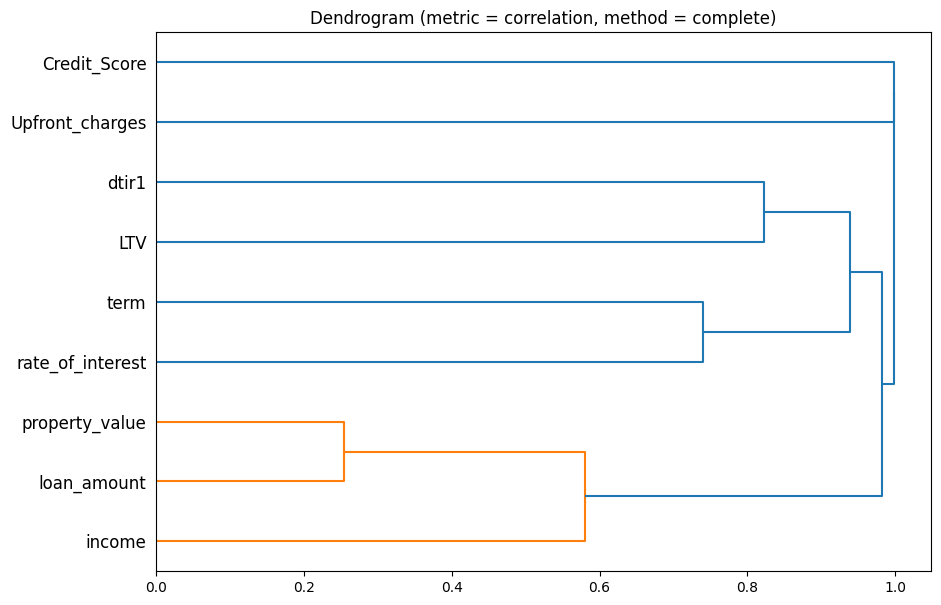

In [16]:
from scipy.spatial.distance import squareform, pdist
from luntaiDs.ModelingTools.FeatureEngineer.transformers import plot_feature_dendrogram

numeric_cols = ts.get_numeric_cols()

def distance_1_corr(m):
    # penalize for correlation > 1, make sure this distance is always < 1
    return 1 - np.abs(1 - pdist(m, metric = 'correlation'))

plot_feature_dendrogram(
    X_train[numeric_cols].dropna(),
    distance_func = distance_1_corr, 
    metric = 'correlation',
    method = 'complete'
)

# 3. Feature Engineering

## 3.1 Feature Selection

https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

### 3.1.1 Filter method - Univariate Feature Selection

numerical features: select features with top 2 anova_f score with target within each group (using agglomerative clustering)
categorical features: select top 80% of features with highest mutual info score with target

In [17]:
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectPercentile
from category_encoders.ordinal import OrdinalEncoder
from luntaiDs.ModelingTools.FeatureEngineer.transformers import MyImputer, MyFeatureSelector, SelectKBestByCluster, SelectThreshold, NamedTransformer
from luntaiDs.ModelingTools.utils.support import make_present_col_selector
from luntaiDs.ModelingTools.FeatureEngineer.preprocessing import get_mutual_info_preprocess

# use MyFeatureSelector as it support pre-processing on features
num_selector = MyFeatureSelector(
    # selector criteria
    selector = SelectKBestByCluster(
        k = 2,  # select top 2 within each cluster
        # score is defined using Anova-F
        scorer = SelectThreshold(
            score_func = f_classif, # use Anova-F as score metric
            threshold = 0.05,  # 95% significant level
            use_p = True, # use p-value instead of F score to filter
        ),
        # cluster is defined using agglomerative clustering
        cluster_kernal = AgglomerativeClustering(
            n_clusters = None, # as we will set distance threshold
            affinity = 'precomputed', # use precomputed scores
            linkage = 'complete', # complete linkage
            distance_threshold = 0.7, # based on dendrogram above 
            compute_full_tree = True
        ),
        distance_func = distance_1_corr # defined above
        
    )
)

# categorical
categ_selector = MyFeatureSelector(
    selector = SelectPercentile(
        # use mutual info for categ features as filtering metric
        score_func = partial(
            mutual_info_classif,
            discrete_features = True,
        ),
        percentile = 50  # keep top 50% of features
    ),
)

num_cols = ts.get_numeric_cols()
categ_cols = ts.get_categ_cols()
# use NamedTransformer wrapper to keep column name
fsel = NamedTransformer(
    ColumnTransformer(
        transformers = [
            ('numeric', num_selector, make_present_col_selector(num_cols)),
            ('categorical', categ_selector, make_present_col_selector(categ_cols))
        ],
        remainder = 'drop'
    )
)
feature_selector_filter = Pipeline([
    ('preprocessing', get_mutual_info_preprocess(ts)),
    ('fsel', fsel)
])
feature_selector_filter.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 NamedTransformer(transformer=ColumnTransformer(transformers=[('loan_limit',
                                                                               Pipeline(steps=[('binarize',
                                                                                                BinaryConverter(pos_values=['cf'])),
                                                                                               ('impute',
                                                                                                MyImputer(fill_value=0,
                                                                                                          strategy='constant'))]),
                                                                               functools.partial(<function _select_present_subset at 0x7f688bff1940>, ['loan_limit'])),
                                                                              ('Gender',
                                                                               Pipeline(steps=[('ordinal',...
                                                                               functools.partial(<function _select_present_subset at 0x7f688bff1940>, ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']))])))])

selected features

In [18]:
feature_selector_filter.get_feature_names_out()

array(['loan_amount', 'Upfront_charges', 'property_value', 'income',
       'LTV', 'dtir1', 'Gender', 'loan_type', 'business_or_commercial',
       'Neg_ammortization', 'lump_sum_payment', 'credit_type',
       'co-applicant_credit_type', 'age', 'submission_of_application',
       'Region'], dtype='<U25')

inspect: numerical features and their pvalues of F-test and the cluster it belongs to

In [19]:
cluster_selector_ = feature_selector_filter['fsel'].transformer.named_transformers_['numeric'].selector_
cluster_selector_.feature_score_cluster_

,Scores,Cluster
loan_amount,1.891946e-132,3
Upfront_charges,0.000000e+00,0
property_value,0.000000e+00,0
income,6.975234e-20,4
LTV,9.661512e-193,1
dtir1,2.079877e-162,2


inspect: categorical features and their mutual info score

In [20]:
categ_selector_ = feature_selector_filter['fsel'].transformer.named_transformers_['categorical'].selector_
#pd.Series(categ_selector_.scores_, index = categ_selector_.feature_names_in_).sort_values(ascending=False)
pd.DataFrame({
        'mutual_info_score' : categ_selector_.scores_,
        'selected': np.isin(
            categ_selector_.feature_names_in_,
            feature_selector_filter.get_feature_names_out()
        )
    },
    index = categ_selector_.feature_names_in_
).sort_values(ascending=False, by = 'mutual_info_score')


,mutual_info_score,selected
credit_type,0.163321,True
lump_sum_payment,0.013590,True
Neg_ammortization,0.010780,True
co-applicant_credit_type,0.010593,True
submission_of_application,0.007026,True
loan_type,0.004111,True
business_or_commercial,0.004005,True
Gender,0.003693,True
age,0.003137,True
Region,0.001313,True


### 3.1.2 Wrapper Method (recursive feature elimination)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from luntaiDs.ModelingTools.FeatureEngineer.preprocessing import get_preliminary_preprocess

rfe = RFECV(
    # use random forest as base filter
    estimator = RandomForestClassifier(n_estimators = 200, n_jobs = -1),
    min_features_to_select = 15,  # keep 50% of features
    scoring = 'average_precision', # we care about precision-recall
    importance_getter = 'auto', # will use feature importance
    cv = 3, # use 3-fold cross validation
    #n_jobs = -1,
    #verbose = 3,
)

feature_selector_wrapper = MyFeatureSelector(
    selector = rfe,
    # need to preprocess feature before feeding into the selector
    preprocess_pipe = get_preliminary_preprocess(ts)
)
feature_selector_wrapper.fit(X_train, y_train)

MyFeatureSelector(preprocess_pipe=NamedTransformer(transformer=ColumnTransformer(transformers=[('loan_limit',
                                                                                                Pipeline(steps=[('binarize',
                                                                                                                 BinaryConverter(pos_values=['cf'])),
                                                                                                                ('impute',
                                                                                                                 MyImputer(fill_value=0,
                                                                                                                           strategy='constant'))]),
                                                                                                functools.partial(<function _select_present_subset at 0x7fa62c15d700>, ['loan_limit'])),
                                                                                               ('Gender',
                                                                                                Pipeline(steps=[('impute',...
                                                                                                                 FunctionTransformer(func=<function floatFy at 0x7fa62c0f7e50>)),
                                                                                                                ('impute',
                                                                                                                 MyImputer(strategy='median')),
                                                                                                                ('scale',
                                                                                                                 NamedTransformer(transformer=RobustScaler()))]),
                                                                                                functools.partial(<function _select_present_subset at 0x7fa62c15d700>, ['dtir1']))])),
                  selector=RFECV(cv=3,
                                 estimator=RandomForestClassifier(n_estimators=200,
                                                                  n_jobs=-1),
                                 min_features_to_select=15,
                                 scoring='average_precision'))

In [ ]:
feature_selector_wrapper.get_feature_names_out()

array(['loan_type', 'loan_purpose', 'loan_amount', 'rate_of_interest',
       'Upfront_charges', 'Neg_ammortization', 'lump_sum_payment',
       'property_value', 'income', 'credit_type',
       'co-applicant_credit_type', 'age', 'submission_of_application',
       'LTV', 'dtir1'], dtype=object)

In [ ]:
pd.DataFrame(feature_selector_wrapper.selector_.cv_results_)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
0,1.0,0.000000e+00,1.0,1.0,1.0
1,1.0,0.000000e+00,1.0,1.0,1.0
2,1.0,0.000000e+00,1.0,1.0,1.0
3,1.0,0.000000e+00,1.0,1.0,1.0
4,1.0,0.000000e+00,1.0,1.0,1.0
5,1.0,0.000000e+00,1.0,1.0,1.0
6,1.0,6.409876e-17,1.0,1.0,1.0
7,1.0,0.000000e+00,1.0,1.0,1.0
8,1.0,0.000000e+00,1.0,1.0,1.0
9,1.0,0.000000e+00,1.0,1.0,1.0


In [ ]:
pd.Series(
    feature_selector_wrapper.selector_.ranking_, 
    feature_selector_wrapper.selector_.feature_names_in_
).sort_values()

lump_sum_payment              1
LTV                           1
submission_of_application     1
age                           1
co-applicant_credit_type      1
credit_type                   1
income                        1
property_value                1
Neg_ammortization             1
Upfront_charges               1
dtir1                         1
loan_amount                   1
loan_type                     1
loan_purpose                  1
rate_of_interest              1
Credit_Score                  2
Gender                        3
term                          4
Credit_Worthiness             5
business_or_commercial        6
open_credit                   7
Region                        8
loan_limit                    9
occupancy_type               10
approv_in_adv                11
interest_only                12
total_units                  13
Secured_by                   14
construction_type            15
Security_Type                16
dtype: int64

### 3.1.3 Embedded Method (Lasso Feature Selection)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from luntaiDs.ModelingTools.FeatureEngineer.transformers import OutlierClipper

emb = SelectFromModel(
    # use random forest as base filter
    estimator = SGDClassifier(
        loss = 'log',
        penalty = 'l1',  # use L1 - Lasso to suppress coefficients
        alpha = 0.001, # regularization scale
        max_iter = 2000,
    ),
    threshold='median', # select feature whose score > median of all scores across features
    importance_getter = 'auto' # use absolute coefficient (normalized X) as selection criteria
)

feature_selector_embed = MyFeatureSelector(
    selector = emb,
    # need to preprocess feature before feeding into the selector
    preprocess_pipe = Pipeline([
        ('preprocess', get_preliminary_preprocess(ts)),
        ('standardize', NamedTransformer(StandardScaler()))
    ])
)
feature_selector_embed.fit(X_train, y_train)

MyFeatureSelector(preprocess_pipe=Pipeline(steps=[('preprocess',
                                                   NamedTransformer(transformer=ColumnTransformer(transformers=[('loan_limit',
                                                                                                                 Pipeline(steps=[('binarize',
                                                                                                                                  BinaryConverter(pos_values=['cf'])),
                                                                                                                                 ('impute',
                                                                                                                                  MyImputer(fill_value=0,
                                                                                                                                            strategy='constant'))]),
                                                                                                                 functools.partial(<function _select_present_subset at 0x7fa62c15d700>, ['loan_limit'])),
                                                                                                                ('Gend...
                                                                                                                                  MyImputer(strategy='median')),
                                                                                                                                 ('scale',
                                                                                                                                  NamedTransformer(transformer=RobustScaler()))]),
                                                                                                                 functools.partial(<function _select_present_subset at 0x7fa62c15d700>, ['dtir1']))]))),
                                                  ('standardize',
                                                   NamedTransformer(transformer=StandardScaler()))]),
                  selector=SelectFromModel(estimator=SGDClassifier(alpha=0.001,
                                                                   loss='log',
                                                                   max_iter=2000,
                                                                   penalty='l1'),
                                           threshold='median'))

In [ ]:
feature_selector_embed.get_feature_names_out()

array(['loan_limit', 'loan_purpose', 'open_credit', 'loan_amount',
       'rate_of_interest', 'Upfront_charges', 'Neg_ammortization',
       'lump_sum_payment', 'property_value', 'occupancy_type', 'income',
       'credit_type', 'age', 'submission_of_application', 'LTV'],
      dtype=object)

In [ ]:
lr_ = feature_selector_embed.selector_.estimator_
pd.DataFrame({
        'coef' : lr_.coef_[0],
        'selected' : np.isin(
            lr_.feature_names_in_, 
            feature_selector_embed.get_feature_names_out()
        )
    },
    index = lr_.feature_names_in_
).sort_values(by = 'coef')

,coef,selected
Upfront_charges,-44.691522,True
property_value,-9.425969,True
LTV,-0.420975,True
rate_of_interest,-0.289204,True
loan_limit,-0.188877,True
open_credit,-0.144767,True
loan_type,-0.131625,False
co-applicant_credit_type,-0.115657,False
Credit_Worthiness,-0.068420,False
Security_Type,-0.003871,False


### 3.1.4 Combining 3 feature selection method results

use 0/1 boolean flag by each method

In [ ]:
select_result = pd.DataFrame({
        'filter' : X_train.columns.isin(feature_selector_filter.get_feature_names_out()),
        'wrapper' : X_train.columns.isin(feature_selector_wrapper.get_feature_names_out()),
        'embed' : X_train.columns.isin(feature_selector_embed.get_feature_names_out())
    },
    index = X_train.columns    
).astype('int')
select_result.style.background_gradient()

,filter,wrapper,embed
loan_limit,0,0,1
Gender,1,0,0
approv_in_adv,0,0,0
loan_type,1,1,0
loan_purpose,0,1,1
Credit_Worthiness,0,0,0
open_credit,0,0,1
business_or_commercial,1,0,0
loan_amount,1,1,1
rate_of_interest,0,1,1


In [ ]:
select_result.sum(axis = 1)[select_result.sum(axis = 1) == 3].index

Index(['loan_amount', 'Upfront_charges', 'Neg_ammortization',
       'lump_sum_payment', 'property_value', 'income', 'credit_type', 'age',
       'submission_of_application', 'LTV'],
      dtype='object')

use ranking as soft selection criterion

In [ ]:
def get_ranking(scores: pd.Series, columns: list, higher_is_better:bool = True):
    r = pd.Series(index = columns, dtype = 'float')
    r[scores.index] = scores.rank(ascending= not higher_is_better)
    return r.fillna(r.max() + 1).astype('int')


filter_num_ranking = get_ranking(
    feature_selector_filter['fsel'].transformer.named_transformers_['numeric'].selector_.selected_feature_score_cluster_['Scores'],
    higher_is_better = False,
    columns = ts.get_numeric_cols()
)
filter_categ_ranking = get_ranking(
    pd.Series(
        feature_selector_filter['fsel'].transformer.named_transformers_['categorical'].selector_.scores_,
        index = feature_selector_filter['fsel'].transformer.named_transformers_['categorical'].selector_.feature_names_in_
    ),
    higher_is_better = False,
    columns = ts.get_categ_cols()
)
filter_ranking = filter_num_ranking.append(filter_categ_ranking)

wrapper_ranking = pd.Series(
    feature_selector_wrapper.selector_.ranking_, 
    feature_selector_wrapper.selector_.feature_names_in_
)
embed_ranking = get_ranking(
    pd.Series(
        np.abs(feature_selector_embed.selector_.estimator_.coef_[0]),
        index = feature_selector_embed.selector_.estimator_.feature_names_in_
    ),
    higher_is_better = True,
    columns = X_train.columns
)

select_ranking = pd.merge(
    filter_ranking.rename('filter'),
    wrapper_ranking.rename('wrapper'),
    left_index = True,
    right_index = True,
    how = 'outer'
).merge(
    embed_ranking.rename('embed'),
    left_index = True,
    right_index = True,
    how = 'outer'
)

(
    select_ranking.style
    .background_gradient(subset = ['filter'])
    .background_gradient(subset = ['wrapper'])
    .background_gradient(subset = ['embed'])
)


,filter,wrapper,embed
Credit_Score,7,2,28
Credit_Worthiness,8,5,21
Gender,14,3,22
LTV,3,1,6
Neg_ammortization,19,1,9
Region,12,8,23
Secured_by,4,14,25
Security_Type,4,16,24
Upfront_charges,1,1,1
age,13,1,14


In [ ]:
select_ranking.sum(axis = 1).sort_values()[:11].index # select top 11 features

Index(['Upfront_charges', 'property_value', 'LTV', 'loan_amount', 'income',
       'rate_of_interest', 'submission_of_application', 'loan_purpose',
       'open_credit', 'credit_type', 'dtir1'],
      dtype='object')

merge the two results

In [ ]:
bool_select_cols = select_result.sum(axis = 1)[select_result.sum(axis = 1) >= 2].index
rank_select_cols = select_ranking.sum(axis = 1).sort_values()[:15].index
selected_cols = bool_select_cols.intersection(rank_select_cols)
selected_cols

Index(['loan_purpose', 'loan_amount', 'rate_of_interest', 'Upfront_charges',
       'Neg_ammortization', 'lump_sum_payment', 'property_value', 'income',
       'credit_type', 'age', 'submission_of_application', 'LTV', 'dtir1'],
      dtype='object')

### 3.1.5 Build a preselector for pipeline

In [ ]:
from luntaiDs.ModelingTools.FeatureEngineer.transformers import PreSelectSelector

fsel_pipe = PreSelectSelector(
    pre_selected_features = selected_cols
)
fsel_pipe.fit_transform(X_train, y_train)

,loan_purpose,loan_amount,rate_of_interest,Upfront_charges,Neg_ammortization,lump_sum_payment,property_value,income,credit_type,age,submission_of_application,LTV,dtir1
0,p3,626500,4.250,18410.00,not_neg,not_lpsm,788000.0,13560.0,EXP,45-54,to_inst,79.505076,36.0
1,p4,246500,4.375,4115.46,not_neg,not_lpsm,448000.0,10500.0,CIB,55-64,to_inst,55.022321,47.0
2,p3,116500,NaN,NaN,not_neg,not_lpsm,128000.0,1860.0,CIB,55-64,to_inst,91.015625,37.0
3,p4,416500,3.625,14160.31,not_neg,not_lpsm,528000.0,8940.0,CIB,25-34,to_inst,78.882576,33.0
4,p4,296500,3.690,7392.04,not_neg,not_lpsm,418000.0,4200.0,CIB,65-74,not_inst,70.933014,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104064,p3,346500,3.750,6794.00,not_neg,not_lpsm,858000.0,5400.0,CRIF,55-64,not_inst,40.384615,37.0
104065,p4,346500,3.750,1250.00,not_neg,not_lpsm,468000.0,6300.0,CIB,45-54,to_inst,74.038462,44.0
104066,p4,126500,3.500,1382.80,not_neg,not_lpsm,138000.0,NaN,EXP,>74,to_inst,91.666667,NaN
104067,p4,696500,3.625,0.00,not_neg,not_lpsm,1208000.0,11340.0,CIB,55-64,not_inst,57.657285,23.0


## 3.2 Feature Preprocessing

https://miro.com/app/board/uXjVMIjlWQM=/?share_link_id=131039308216

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.base import clone
from luntaiDs.ModelingTools.FeatureEngineer.transformers import NamedTransformer, BucketCategByFsel, BucketCategValue, OutlierClipper, MyImputer
from luntaiDs.ModelingTools.Explore.profiling import log10pc, exp10pc
from luntaiDs.ModelingTools.FeatureEngineer.preprocessing import nominal_categ_preprocess_pipe,  ordinal_categ_preprocess_pipe, \
        binary_preprocess_pipe, numeric_preprocess_pipe

transformers = []    
for col, stat in ts.configs.items():
    if col in ts.get_nominal_cols():
        transformer = nominal_categ_preprocess_pipe(
            cs = stat,
            impute_value = 'Other',
            bucket_strategy = 'correlation',
            encode_strategy = 'woe' # does not support shuffling in CV, bug
        )
    elif col in ts.get_ordinal_cols():
        transformer = ordinal_categ_preprocess_pipe(
            os = stat,
            impute = True,
            standardize = False
        )
    elif col in ts.get_binary_cols():
        transformer = binary_preprocess_pipe(
            bs = stat
        )
    elif col in ts.get_numeric_cols():
        transformer = numeric_preprocess_pipe(
            ns = stat,
            impute = True,
            normalize = True,
            standardize_strategy = 'robust'
        )
    
    transformers.append((col, transformer, make_present_col_selector([col])))
    
preprocessing_pipe = Pipeline([
    ('transform', NamedTransformer(
        ColumnTransformer(
            transformers,
            remainder='drop'
        )
    )),
    ('float', NamedTransformer(FunctionTransformer(floatFy)))
])
preprocessing_pipe.fit(fsel_pipe.fit_transform(X_train, y_train), y_train)

Pipeline(steps=[('transform',
                 NamedTransformer(transformer=ColumnTransformer(transformers=[('loan_limit',
                                                                               Pipeline(steps=[('binarize',
                                                                                                BinaryConverter(pos_values=['cf'])),
                                                                                               ('impute',
                                                                                                MyImputer(fill_value=0,
                                                                                                          strategy='constant'))]),
                                                                               functools.partial(<function _select_present_subset at 0x7fa62c15d700>, ['loan_limit'])),
                                                                              ('Gender',
                                                                               Pipeline(steps=[('impute',
                                                                                                MyImp...
                                                                                                MyImputer(strategy='median')),
                                                                                               ('normalize',
                                                                                                NamedTransformer(transformer=PowerTransformer(standardize=False))),
                                                                                               ('scale',
                                                                                                NamedTransformer(transformer=RobustScaler()))]),
                                                                               functools.partial(<function _select_present_subset at 0x7fa62c15d700>, ['dtir1']))]))),
                ('float',
                 NamedTransformer(transformer=FunctionTransformer(func=<function floatFy at 0x7fa62c0f7e50>)))])

In [ ]:
preprocessing_pipe.transform(fsel_pipe.transform(X_train))

,loan_purpose,loan_amount,rate_of_interest,Upfront_charges,property_value,income,credit_type,age,submission_of_application,LTV,dtir1
0,0.021393,1.064972,0.406332,0.221766,0.824183,1.181055,-0.551702,3.0,1.0,0.212100,-0.268608
1,-0.097971,-0.224739,0.644434,0.128095,0.179954,0.814265,-0.551507,4.0,1.0,-0.844426,0.778005
2,0.021393,-1.003409,0.000000,-0.877616,-1.008301,-1.008529,-0.551507,4.0,1.0,0.815612,-0.180519
3,-0.097971,0.451606,-0.856685,0.221766,0.359972,0.598030,-0.551507,1.0,1.0,0.181373,-0.524018
4,-0.097971,0.000000,-0.719220,0.184317,0.105787,-0.281045,-0.551507,5.0,0.0,-0.193512,-0.355231
...,...,...,...,...,...,...,...,...,...,...,...
104064,0.021393,0.200777,-0.593668,0.176284,0.927651,-0.012337,-0.511397,4.0,0.0,-1.321929,-0.180519
104065,-0.097971,0.200777,-0.593668,0.010146,0.227226,0.163868,-0.551507,3.0,1.0,-0.050944,0.475982
104066,-0.097971,-0.927516,-1.125416,0.020338,-0.945579,-2.657639,-0.551702,6.0,1.0,0.851735,0.000000
104067,-0.097971,1.237698,-0.856685,-0.877616,1.317245,0.921624,-0.551507,4.0,0.0,-0.745955,-1.274085


# 4. Model training

## 4.1 Hyperparameter Tuning

In [ ]:
from warnings import simplefilter
simplefilter("ignore", category=UserWarning)
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
from optuna.integration import OptunaSearchCV
optuna.logging.set_verbosity(optuna.logging.INFO)

optuna_storage = "sqlite:////home/luntaixia/Downloads/demo_optuna_tuning.db"
study_name = "loan-default-modeling"

study = optuna.create_study(
    storage = optuna_storage,
    study_name = study_name,
    pruner = MedianPruner(),
    direction = 'maximize',
    sampler = TPESampler(),
    load_if_exists = True
)

hyper_tuner = OptunaSearchCV(
    estimator = LGBMClassifier(
        objective='binary', 
        n_estimators=50, 
        boosting_type='gbdt', 
        importance_type='gain',
        class_weight='balanced'
    ),
    param_distributions={
        # preprocessing parameter
        # 'preprocess__transformer__numeric_log__impute__strategy': CategoricalDistribution(choices=('mean', 'median')),
        # 'preprocess__transformer__numeric_log__outlier__strategy': CategoricalDistribution(choices=('iqr', 'quantile')),
        # 'preprocess__transformer__numeric_log__outlier__quantile_range': CategoricalDistribution(choices=((1, 99), (5, 95))),
        # 'preprocess__transformer__numeric_non_log__outlier__strategy': CategoricalDistribution(choices=('iqr', 'quantile')),
        # 'preprocess__transformer__numeric_non_log__outlier__quantile_range': CategoricalDistribution(choices=((1, 99), (5, 95))),
        # boosting regularization
        'learning_rate': FloatDistribution(0.001, 0.35, log=True),
        'reg_alpha': FloatDistribution(1e-6, 1e2, log=True),  # l1
        'reg_lambda': FloatDistribution(1e-6, 1e2, log=True),  # l2
        # tree regularization
        'max_depth': IntDistribution(3, 12, step=3),
        'num_leaves': IntDistribution(20, 100, step=10),
        'min_split_gain': FloatDistribution(1e-3, 1e2, log=True),  # min_split_loss
        'subsample': FloatDistribution(0.3, 1, step=0.1),
        'min_child_weight': IntDistribution(1, 20),
        'colsample_bytree': FloatDistribution(0.3, 1, step=0.1),
        # class-imbalance parameters
        'class_weight': CategoricalDistribution(choices = ['balanced', None]),
    },
    cv = 3, # 3-fold cross validation
    error_score = 'raise',
    n_trials = 100, # do 100 trials on hyperparameter study
    refit = True, # will retrain on all trainingd data after cross validation
    return_train_score = True,
    scoring = 'average_precision',
    study = study,
    verbose = 3,
)

model_pipeline = Pipeline([
    ('fsel', fsel_pipe),
    ('preprocess', preprocessing_pipe),
    ('model', hyper_tuner)
])
model_pipeline.fit(X_train, y_train)

[I 2023-09-22 11:30:51,668] A new study created in RDB with name: loan-default-modeling
/tmp/ipykernel_1226044/2367185629.py:23: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  hyper_tuner = OptunaSearchCV(
[I 2023-09-22 11:30:52,344] Searching the best hyperparameters using 104069 samples...
[I 2023-09-22 11:30:52,689] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.3309117220827346, 'reg_alpha': 23.4376451168716, 'reg_lambda': 0.00023846776163317064, 'max_depth': 9, 'num_leaves': 70, 'min_split_gain': 0.008294048946329916, 'subsample': 0.4, 'min_child_weight': 11, 'colsample_bytree': 0.7, 'class_weight': 'balanced'}. Best is trial 0 with value: 1.0.
[I 2023-09-22 11:30:53,054] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.011163617865373204, 'reg_alpha': 0.00014124602398091535, 'reg_lambda': 0.2540811862977074, 'max_depth': 6, 'num_leaves': 80, 'min_split_gain': 1.27608

Pipeline(steps=[('fsel',
                 PreSelectSelector(pre_selected_features=Index(['loan_purpose', 'loan_amount', 'rate_of_interest', 'Upfront_charges',
       'property_value', 'income', 'credit_type', 'age',
       'submission_of_application', 'LTV', 'dtir1'],
      dtype='object'))),
                ('preprocess',
                 Pipeline(steps=[('transform',
                                  NamedTransformer(transformer=ColumnTransformer(transformers=[('...
                                                     'num_leaves': IntDistribution(high=100, log=False, low=20, step=10),
                                                     'reg_alpha': FloatDistribution(high=100.0, log=True, low=1e-06, step=None),
                                                     'reg_lambda': FloatDistribution(high=100.0, log=True, low=1e-06, step=None),
                                                     'subsample': FloatDistribution(high=1.0, log=False, low=0.3, step=0.1)},
                                return_train_score=True,
                                scoring='average_precision',
                                study=<optuna.study.study.Study object at 0x7f70f3676f10>,
                                verbose=3))])

In [ ]:
# start optuna dashboard
optuna-dashboard sqlite:////home/luntaixia/Downloads/demo_optuna_tuning.db

In [ ]:
hyper_tuner.best_params_

{'class_weight': 'balanced',
 'colsample_bytree': 0.7,
 'learning_rate': 0.3309117220827346,
 'max_depth': 9,
 'min_child_weight': 11,
 'min_split_gain': 0.008294048946329916,
 'num_leaves': 70,
 'reg_alpha': 23.4376451168716,
 'reg_lambda': 0.00023846776163317064,
 'subsample': 0.4}

In [ ]:
hyper_tuner.study_.trials_dataframe(attrs = ['value', 'params']).sort_values(by = 'value', ascending = False).head()

,value,params_class_weight,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_min_split_gain,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample
0,1.0,balanced,0.7,0.330912,9,11,0.008294,70,23.437645,0.000238,0.4
61,1.0,balanced,0.5,0.002527,6,3,2.484439,70,0.001776,0.000022,0.6
71,1.0,balanced,0.7,0.122357,3,10,0.564601,30,10.365470,0.001004,0.8
70,1.0,None,0.8,0.071884,9,11,0.103086,50,0.067134,0.003169,0.3
69,1.0,balanced,0.8,0.020233,9,9,0.114119,30,7.223041,0.000843,0.8


## 4.2 Model Calibration (binary classification model)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, IsotonicRegression

calib = CalibratedClassifierCV(
    base_estimator = model_pipeline,
    method = 'isotonic',  # use isotonic regression for non-parametric approach
    cv = 'prefit',
)
calib.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('fsel',
                                                       PreSelectSelector(pre_selected_features=Index(['loan_purpose', 'loan_amount', 'rate_of_interest', 'Upfront_charges',
       'property_value', 'income', 'credit_type', 'age',
       'submission_of_application', 'LTV', 'dtir1'],
      dtype='object'))),
                                                      ('preprocess',
                                                       Pipeline(steps=[('transform',
                                                                        NamedTransformer(transfor...
                                                                                           'reg_alpha': FloatDistribution(high=100.0, log=True, low=1e-06, step=None),
                                                                                           'reg_lambda': FloatDistribution(high=100.0, log=True, low=1e-06, step=None),
                                                                                           'subsample': FloatDistribution(high=1.0, log=False, low=0.3, step=0.1)},
                                                                      return_train_score=True,
                                                                      scoring='average_precision',
                                                                      study=<optuna.study.study.Study object at 0x7f70f3676f10>,
                                                                      verbose=3))]),
                       cv='prefit', method='isotonic')

In [ ]:
from sklearn.calibration import calibration_curve
from luntaiDs.ModelingTools.Evaluation.plots import chart_calibration_curve

prob_true_train_precalib, prob_pred_train_precalib = calibration_curve(
    y_true = y_train, 
    y_prob = model_pipeline.predict_proba(X_train)[:,1], 
    normalize=False, 
    n_bins=20, 
    strategy='uniform'
)
prob_true_train, prob_pred_train = calibration_curve(
    y_true = y_train, 
    y_prob = calib.predict_proba(X_train)[:,1], 
    normalize=False, 
    n_bins=20, 
    strategy='uniform'
)
prob_true_test, prob_pred_test = calibration_curve(
    y_true = y_test, 
    y_prob = calib.predict_proba(X_test)[:,1], 
    normalize=False, 
    n_bins=20, 
    strategy='uniform'
)

fig = chart_calibration_curve(
    cali_curves={
        'pre-calib' : {
            'prob_true': prob_true_train_precalib.tolist(),
            'prob_pred': prob_pred_train_precalib.tolist(),
        },
        'train' : {
            'prob_true': prob_true_train.tolist(),
            'prob_pred': prob_pred_train.tolist(),
        },
        'test' : {
            'prob_true': prob_true_test.tolist(),
            'prob_pred': prob_pred_test.tolist(),
        }
    },
    size = (600, 300)
)
show(fig)

In [ ]:
from joblib import dump

dump(calib, filename='/media/sf_iphone/credit-modeling.joblib')

['/media/sf_iphone/credit-modeling.joblib']

# 5. Model Evaluation

In [ ]:
from joblib import load

modeling = load('/media/sf_iphone/credit-modeling.joblib')

In [ ]:
from sklearn.metrics import classification_report

r = classification_report(
    y_true = y_test.values,
    y_pred = modeling.predict(X_test),
)
print(r)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33609
           1       1.00      1.00      1.00     10992

    accuracy                           1.00     44601
   macro avg       1.00      1.00      1.00     44601
weighted avg       1.00      1.00      1.00     44601



In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_prob = modeling.predict_proba(X_test)[:,1]
print(
    roc_auc_score(y_test.values, y_prob), 
    average_precision_score(y_test.values, y_prob)
)

1.0 1.0


In [ ]:
from luntaiDs.ModelingTools.Evaluation.metrics import binary_clf_metric_at_thresholds

binary_metrics_train = binary_clf_metric_at_thresholds(y_train, modeling.predict_proba(X_train)[:,1])
binary_metrics_test = binary_clf_metric_at_thresholds(y_test, modeling.predict_proba(X_test)[:,1])

In [ ]:
from luntaiDs.ModelingTools.Evaluation.plots import chart_roc_curve

fig = chart_roc_curve(
    binary_metrics_train,
    binary_metrics_test,
    names = ['train', 'test']
)
show(fig)

In [ ]:
from luntaiDs.ModelingTools.Evaluation.plots import chart_pr_curve

fig = chart_pr_curve(
    binary_metrics_train,
    binary_metrics_test,
    names = ['train', 'test']
)
show(fig)

In [ ]:
from luntaiDs.ModelingTools.Evaluation.plots import chart_confusion_maxtrix

fig = chart_confusion_maxtrix(metrics = binary_metrics_test,)
show(fig)

# 6. Model Interpretation

## 6.1 Feature Importance

In [ ]:
from luntaiDs.ModelingTools.Explore.plots import chart_barchart

importance_chart = chart_barchart(
    pd.Series(
        modeling.base_estimator['model'].best_estimator_.feature_importances_,
        index = modeling.base_estimator['preprocess'].get_feature_names_out()
    ).sort_values(ascending = False),
    max_bar=50,
    size = (900, 600),
    title="Feature Importances by Feature"
)
show(importance_chart)

## 6.2 Shap Interpretation

https://www.depends-on-the-definition.com/shapley-values-from-scratch/

In [ ]:
X_train_premodel = modeling.base_estimator[:-1].transform(X_train)
X_test_premodel = modeling.base_estimator[:-1].transform(X_test)
X_train_premodel

,loan_purpose,loan_amount,rate_of_interest,Upfront_charges,property_value,income,credit_type,age,submission_of_application,LTV,dtir1
0,0.021393,1.064972,0.406332,0.221766,0.824183,1.181055,-0.551702,3.0,1.0,0.212100,-0.268608
1,-0.097971,-0.224739,0.644434,0.128095,0.179954,0.814265,-0.551507,4.0,1.0,-0.844426,0.778005
2,0.021393,-1.003409,0.000000,-0.877616,-1.008301,-1.008529,-0.551507,4.0,1.0,0.815612,-0.180519
3,-0.097971,0.451606,-0.856685,0.221766,0.359972,0.598030,-0.551507,1.0,1.0,0.181373,-0.524018
4,-0.097971,0.000000,-0.719220,0.184317,0.105787,-0.281045,-0.551507,5.0,0.0,-0.193512,-0.355231
...,...,...,...,...,...,...,...,...,...,...,...
104064,0.021393,0.200777,-0.593668,0.176284,0.927651,-0.012337,-0.511397,4.0,0.0,-1.321929,-0.180519
104065,-0.097971,0.200777,-0.593668,0.010146,0.227226,0.163868,-0.551507,3.0,1.0,-0.050944,0.475982
104066,-0.097971,-0.927516,-1.125416,0.020338,-0.945579,-2.657639,-0.551702,6.0,1.0,0.851735,0.000000
104067,-0.097971,1.237698,-0.856685,-0.877616,1.317245,0.921624,-0.551507,4.0,0.0,-0.745955,-1.274085


### 6.2.1 train a shap model (instance-based, not model based) on the training data

In [ ]:
import shap

explainer = shap.TreeExplainer(
    model = modeling.base_estimator['model'].best_estimator_,
    data = X_train_premodel, # specify this
    model_output = 'probability'  # explain the output of the model transformed into probability space 
    # (note that this means the SHAP values now sum to the probability output of the model)
)
#shap_values = explainer.shap_values(X_train_premodel)
#shap_values

In [ ]:
from joblib import dump

dump(explainer, "/media/sf_iphone/credit-modeling-explainer.joblib")

['/media/sf_iphone/credit-modeling-explainer.joblib']

In [ ]:
from joblib import load
import shap

explainer = load("/media/sf_iphone/credit-modeling-explainer.joblib")

### 6.2.2 portfolio level (global) explanation on training data

In [ ]:
exps_train = explainer(X_train_premodel) # apply shap model on training set
exps_train  # support indexing for specific sample

 98%|===================| 101927/104069 [00:12<00:00]       

.values =
array([[ 4.53504560e-04, -2.51130950e-05, -1.77942939e-01, ...,
         4.08652659e-04, -7.45454666e-05, -4.75173084e-05],
       [ 4.01888936e-05, -2.76020012e-07, -1.77942939e-01, ...,
         4.08652659e-04, -4.04565371e-05,  8.98668012e-05],
       [ 8.94937278e-04,  4.81167493e-04,  4.89393767e-01, ...,
         3.27182061e-03,  3.89588456e-04, -1.50978720e-04],
       ...,
       [-2.85623233e-06,  6.62318279e-05, -1.76859323e-01, ...,
         3.70013136e-04,  7.51302091e-05, -4.83133070e-05],
       [-9.00436797e-04, -4.42145412e-04, -2.45969471e-01, ...,
        -2.55445848e-03,  7.14386102e-05, -1.04268320e-04],
       [-1.37828043e-03, -2.16234259e-04, -2.47555642e-01, ...,
        -2.58298005e-03,  7.21181519e-05, -1.05501768e-04]])

.base_values =
array([0.31042429, 0.31042429, 0.31042429, ..., 0.31042429, 0.31042429,
       0.31042429])

.data =
array([[ 0.02139303,  1.06497196,  0.4063323 , ...,  1.        ,
         0.21209959, -0.26860817],
       [-0.09797

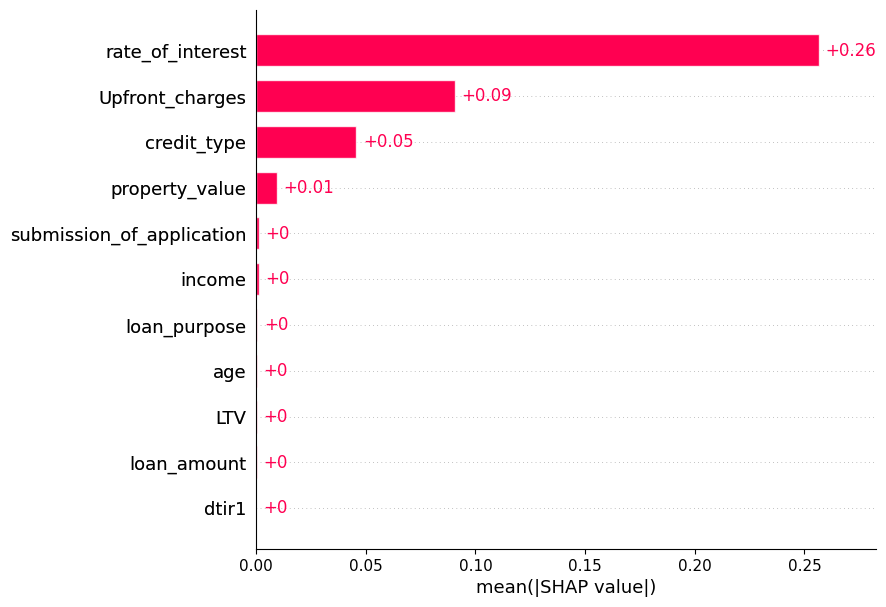

In [ ]:
# global level feature importance
# shap.summary_plot(shap_values, X_train_premodel, plot_type='bar')
shap.plots.bar(exps_train, max_display = 50)

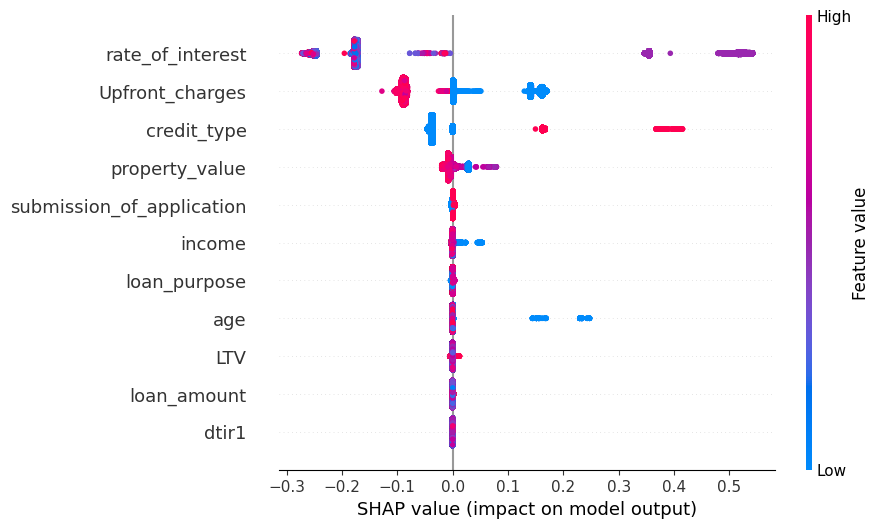

In [ ]:
shap.plots.beeswarm(
    exps_train,
    max_display = 22
)

### 6.2.3 instance level (local) explanation on testing data

In [ ]:
# note it is different from explainer(X_test_premodel.iloc[25, :])
exp_sample = explainer(X_test_premodel.iloc[[25], :])[0]  # explanation type
pd.Series(
    exp_sample.values,
    index = exp_sample.feature_names).sort_values(
        key = np.abs, 
        ascending = False
)

rate_of_interest             0.520889
Upfront_charges              0.160826
submission_of_application    0.003915
property_value               0.002947
loan_purpose                 0.000341
LTV                          0.000305
income                      -0.000166
dtir1                       -0.000152
age                         -0.000127
credit_type                 -0.000089
loan_amount                 -0.000014
dtype: float64

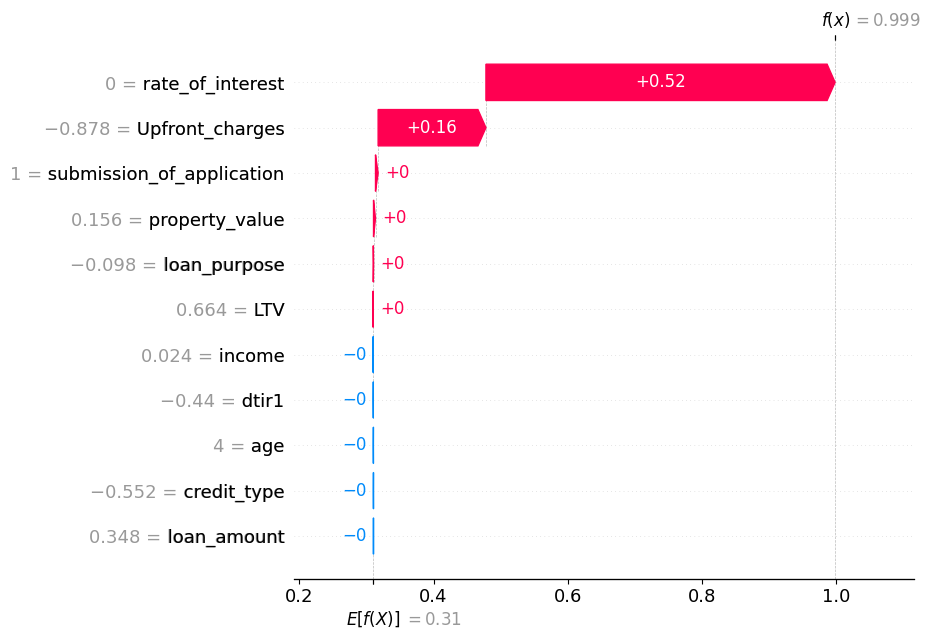

In [ ]:
# local instance level explanation
shap.plots.waterfall(exp_sample, max_display=50)

In [ ]:
shap.initjs()
shap.plots.force(exp_sample)